In [1]:
!pip install datasets
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, load_metric
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainingArguments, Trainer
from transformers import pipeline
import json
import os
from google.colab import drive
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
models_path = '/content/gdrive/My Drive/models/'
model_name = 'sentiment-analysis-custom'
model_path = os.path.join(models_path,model_name)
print(model_path)

/content/gdrive/My Drive/models/sentiment-analysis-custom


In [6]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-07-23 19:32:24--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  1.23MB/s    in 2.6s    

2023-07-23 19:32:28 (1.23 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [7]:
df = pd.read_csv('AirlineTweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df[['airline_sentiment','text']].copy()

In [10]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

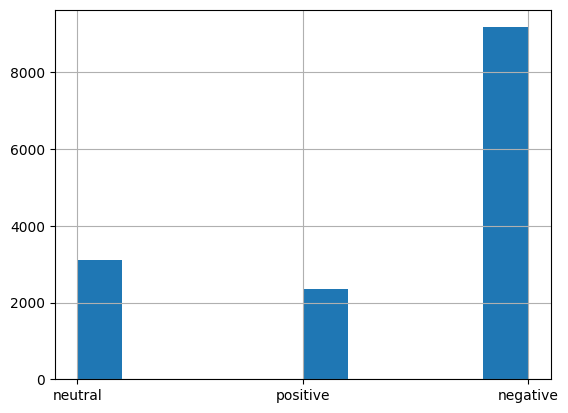

In [10]:
df['airline_sentiment'].hist()

In [9]:
target_map = {'positive':1,'negative':0,'neutral':2}

In [10]:
df['target'] = df['airline_sentiment'].map(target_map)

In [13]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [11]:
df2 = df[['text','target']]
df2.columns = ['sentence','label']
df2.to_csv('data.csv',index=None)

In [15]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0d803de64cfa9373/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [13]:
split = raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [20]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [16]:
checkpoint = 'distilbert-base-cased'

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [18]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [19]:
tokenized_datasets = split.map(tokenize_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
!pip install torchinfo

In [22]:
from torchinfo import summary

In [23]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [24]:
training_args = TrainingArguments(
    output_dir=model_path,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [25]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits,axis=-1)
  acc = np.mean(predictions==labels)
  f1 = f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}

In [26]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [27]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539100,0.424756,0.832650,0.771637
2,0.352400,0.479558,0.834927,0.772545
3,0.227500,0.637593,0.836749,0.784302


TrainOutput(global_step=1923, training_loss=0.32333114949353836, metrics={'train_runtime': 213.3002, 'train_samples_per_second': 144.135, 'train_steps_per_second': 9.015, 'total_flos': 387616869956304.0, 'train_loss': 0.32333114949353836, 'epoch': 3.0})

In [14]:
from transformers import pipeline

In [15]:
savedmodel = pipeline('text-classification',
                      model=os.path.join(model_path,'checkpoint-1282'),
                      device=0)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [16]:
test_pred = savedmodel(split['test']['sentence'])

In [33]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9567224979400635},
 {'label': 'LABEL_1', 'score': 0.9609591364860535},
 {'label': 'LABEL_0', 'score': 0.4746275544166565},
 {'label': 'LABEL_1', 'score': 0.8353070616722107},
 {'label': 'LABEL_2', 'score': 0.553805410861969},
 {'label': 'LABEL_0', 'score': 0.996248185634613},
 {'label': 'LABEL_2', 'score': 0.7440807223320007},
 {'label': 'LABEL_2', 'score': 0.709416389465332},
 {'label': 'LABEL_1', 'score': 0.9354708194732666},
 {'label': 'LABEL_0', 'score': 0.9933892488479614},
 {'label': 'LABEL_0', 'score': 0.9937114715576172},
 {'label': 'LABEL_0', 'score': 0.9962211847305298},
 {'label': 'LABEL_1', 'score': 0.9760414958000183},
 {'label': 'LABEL_0', 'score': 0.9941076040267944},
 {'label': 'LABEL_2', 'score': 0.962302029132843},
 {'label': 'LABEL_2', 'score': 0.5416644811630249},
 {'label': 'LABEL_2', 'score': 0.36038562655448914},
 {'label': 'LABEL_0', 'score': 0.9968340992927551},
 {'label': 'LABEL_0', 'score': 0.9286853075027466},
 {'label': 'LAB

In [17]:
def get_label(d):
  return int(d['label'].split('_')[1])

In [18]:
test_pred = [get_label(d) for d in test_pred]

In [21]:
print("acc:",accuracy_score(split['test']['label'],test_pred))

acc: 0.8349271402550091


In [22]:
print("acc:",f1_score(split['test']['label'],test_pred,average='macro'))

acc: 0.7725452382595038


In [23]:
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm,index=classes,columns=classes)
  ax = sn.heatmap(df_cm,annot=True,fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Target')

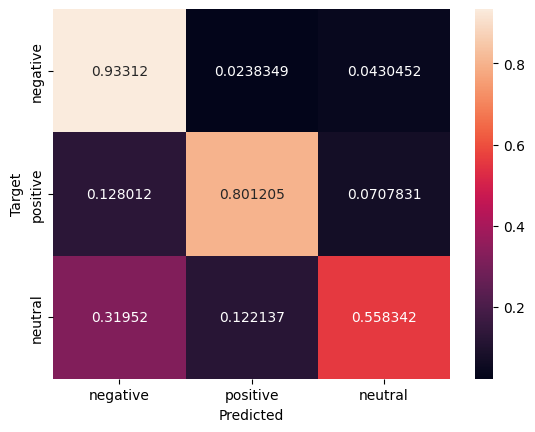

In [24]:
cm = confusion_matrix(split['test']['label'],test_pred,normalize='true')
plot_cm(cm)